In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns

In [39]:
class SocialSpatialModel:
    def __init__(self, grid_size, subpopulations, n_infected,
                 contact_rates, exposure_rate, recovery_rate,
                 epsilon, baseline_activity_rate, income_values):
            self.m = grid_size
            self.N_k = np.array(subpopulations)
            self.I_0 = np.array(n_infected)
            self.A = np.array(contact_rates)  # This will be adjusted based on activity rates
            self.alpha = exposure_rate
            self.gamma = recovery_rate
            self.epsilon = epsilon
            self.baseline_activity_rate = baseline_activity_rate
            self.income_values = income_values
            self.Q = self.compute_vulnerability(income_values)  # update use logistic model
            self.A = self.compute_activity_rate()  # 3.7: update activity rate using the compute activity rate method.
            self.B = self.compute_beta()


    def compute_beta(self):
        m2 = self.m**2
        B = np.zeros((m2, m2)) # initialize beta with zeros

        denominator = np.sum(self.A * self.N_k) # denominator of the beta formula
        indices_2d = [(i // self.m, i % self.m) for i in range(m2)] # change to 2d grid index, for checking neighbor

        # case 1: i and j are neighbors (up, down, left, right)
        for i in range(m2):
            for j in range(m2):
                if i != j:
                    diff = (abs(indices_2d[i][0] - indices_2d[j][0]), abs(indices_2d[i][1] - indices_2d[j][1]))
                    if diff in [(1, 0), (0, 1)]:  # check for up, down, left, right
                        B[i, j] = (1 - self.epsilon) * self.Q[i] * self.A[i] * self.A[j] / denominator
        # case 2: i = j, self transmission rate
        for i in range(m2):
            B[i, i] = (1 - self.epsilon) * self.Q[i] * self.A[i]**2 / denominator + self.epsilon * self.Q[i] * self.A[i] / self.N_k[i]

        return B

    def compute_vulnerability(self, income_levels):
        # vulnerability based on income levels
        logit_q = np.zeros_like(income_levels, dtype=float)
        for i, income in enumerate(income_levels):
            Z1 = 1 if 0.20 <= income < 0.30 else 0  # T1
            Z2 = 1 if income >= 0.30 else 0  # T2
            logit_q[i] = -2 + Z1 + 2 * Z2

        # turn logit to probability
        q = 1 / (1 + np.exp(-logit_q))
        return q

    def compute_activity_rate(self):
        mul = np.random.uniform(0.8, 2, size = self.N_k.shape)
        # baseline_activity_rate = 12
        baseline_activity_rate = 8
        adjusted_activity_rate = baseline_activity_rate * mul
        return adjusted_activity_rate

    def get_initial_state(self):
        # need to return X where X = (S, E, I, R)
        S0 = self.N_k - self.I_0
        E0 = np.zeros_like(self.N_k)
        I0 = self.I_0
        R0 = np.zeros_like(self.N_k)
        return np.concatenate([S0, E0, I0, R0])  # N^2 * 4 # a vector

    def derivative(self, X, t):
        m2 = self.m**2
        S, E, I, R = X[:m2], X[m2:2*m2], X[2*m2:3*m2], X[3*m2:]

        dsdt = -self.B @ I * S
        dedt = self.B @ I * S - self.alpha * E
        didt = self.alpha * E - self.gamma * I
        drdt = self.gamma * I
        return np.concatenate([dsdt, dedt, didt, drdt])  # this should be a vector of length N^2 * 4

In [40]:
def initialize_model(grid_size, pop_grid, initial_infected, income_values,
                     epsilon, exposure_rate, recovery_rate,
                     contact_rates = None, baseline_activity_rate=12):
    pop = pop_grid.flatten()
    n_infected = np.zeros_like(pop)

    # mark the initial infected cell
    n_infected[grid_size * initial_infected[0] + initial_infected[1]] = 1

    if contact_rates is None:
        contact_rates = np.full(pop.shape, 1.0)

    model = SocialSpatialModel(grid_size = grid_size,
                               subpopulations = pop - n_infected,
                               n_infected = n_infected,
                               contact_rates = contact_rates,
                               exposure_rate = exposure_rate,
                               recovery_rate = recovery_rate,
                               epsilon = epsilon,
                               baseline_activity_rate = baseline_activity_rate,
                               income_values = income_values)
    return model

In [41]:
def run_simulation(model, days=30, dt=1.0):
    sus_record = np.zeros((model.m**2, int(days / dt)))
    exp_record = np.zeros((model.m**2, int(days / dt)))
    inf_record = np.zeros((model.m**2, int(days / dt)))
    recovery_record = np.zeros((model.m**2, int(days / dt)))
    X = model.get_initial_state().astype(np.float64)
    for day in range(int(days/dt)):
        dXdt = model.derivative(X, day * dt)
        X += dXdt * dt

        num = model.m ** 2
        S, E, I, R = X[:num], X[num:2*num], X[2*num:3*num], X[3*num:]

        sus_record[:, day] = S
        exp_record[:, day] = E
        inf_record[:, day] = I # update the record for each cell infectious number
        recovery_record[:, day] = R
    return I, sus_record, exp_record, inf_record, recovery_record

def plot_detailed_info(model):
    fig, axes = plt.subplots(model.m, model.m, figsize=(9, 15))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i in range(model.m):
        for j in range(model.m):
            ax = axes[i, j]
            idx = i * model.m + j  # convert 2d index to 1d
            ax.plot([0, 1], [0, 1], ' ', label=f"Cell ({i+1}, {j+1})")

            # pop
            pop = f'Population: {model.N_k[idx]}'
            ax.text(0.5, 0.7, pop, ha='center', fontsize=10, color='blue', transform=ax.transAxes)

            # activity rate
            activity = f'Activity Rate: {model.A[idx]:.2f}'
            ax.text(0.5, 0.5, activity, ha='center', fontsize=10, color='green', transform=ax.transAxes)

            # vul (q)
            vul = f'Vulnerability (Q): {model.Q[idx]:.2f}'
            ax.text(0.5, 0.3, vul, ha='center', fontsize=10, color='red', transform=ax.transAxes)

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_frame_on(False)
            ax.legend(loc='upper center', fontsize=9)

    plt.show()

def plot_infectious(infectious_record, recovery_record, days, dt=1.0, plot_recovery=False):
    fig, axs = plt.subplots(3, 3, sharey=True, figsize=(9, 9))
    t = np.arange(0, days, dt)
    for i in range(3):
        for j in range(3):
            ax = axs[i, j]
            cell_index = i * 3 + j

            ax.plot(t, infectious_record[cell_index], label='Infectious', color='blue')

            if plot_recovery:
                ax.plot(t, recovery_record[cell_index], label='Exposed', color='orange')

            ax.set_title(f'Cell ({i+1}, {j+1})')
            ax.set_xlabel('Days')
            ax.set_ylabel('Population')
            ax.legend(loc='upper left')

            if len(t) > 0 and len(infectious_record[cell_index]) > 0:
                peak_day = np.argmax(infectious_record[cell_index])
                peak_value = infectious_record[cell_index][peak_day]

                ax.axvline(x=peak_day * dt, color='red', linestyle='--')

                ax.text(peak_day * dt, peak_value, f'Peak Day {peak_day}',
                        color='red', va='bottom', fontsize=9, fontweight='semibold')

    plt.tight_layout()
    plt.show()


def plot_SEIR(X, days, grid_size=3, dt=1.0):
    num_cells = grid_size ** 2
    t = np.arange(0, days, dt)
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))  # Adjust subplot grid as needed

    for cell in range(num_cells):
        i, j = divmod(cell, grid_size)
        S, E, I, R = X[cell], X[cell + num_cells], X[cell + 2*num_cells], X[cell + 3*num_cells]

        ax = axs[i, j]
        ax.plot(t, S, label='Susceptible')
        ax.plot(t, E, label='Exposed')
        ax.plot(t, I, label='Infectious')
        ax.plot(t, R, label='Recovered')

        ax.set_title(f'Cell {i+1}, {j+1}')
        ax.set_xlabel('Days')
        ax.set_ylabel('Population')
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_agg_SEIR(sus_record, exp_record, inf_record, recovery_record, pop_grid, days, dt=1.0):
    t = np.arange(0, days, dt)

    I_total = np.sum(inf_record, axis=0)
    E_total = np.sum(exp_record, axis=0)
    S_total = np.sum(sus_record, axis=0)
    R_total = np.sum(recovery_record, axis=0)


    total_pop = np.sum(pop_grid)
    S_total = total_pop - I_total - E_total  # Placeholder calculation
    # R_total = np.zeros_like(I_total)  # Placeholder, assume no recovery initially

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(t, S_total, label='Susceptible', color='skyblue')
    plt.plot(t, E_total, label='Exposed', color='orange')
    plt.plot(t, I_total, label='Infectious', color='red')
    plt.plot(t, R_total, label='Recovered', color='green')

    plt.title('Aggregate SEIR Dynamics')
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_final_heatmap(model, grid_infection):
    infected_pop = grid_infection.reshape(model.m, model.m)

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(infected_pop, cmap='viridis', interpolation='nearest')

    for i in range(infected_pop.shape[0]):
        for j in range(infected_pop.shape[1]):
            text = ax.text(j, i, f'{infected_pop[i, j]:.4f}', ha="center", va="center", color="w", fontsize=12)

    plt.colorbar(cax, label='Infected Population')
    plt.title('Infected Population Heatmap after n Days')
    plt.xlabel('Cell X Coordinate')
    plt.ylabel('Cell Y Coordinate')
    plt.show()

## Experiment 1: Segregated Map

set $\epsilon = 0.9$ to see what will happen?

/var/folders/2x/7qv0s52j78qgnfcjcn6x0n_r0000gn/T/ipykernel_1999/3613230575.py:70: RuntimeWarning: overflow encountered in multiply
  dsdt = -self.B @ I * S
/var/folders/2x/7qv0s52j78qgnfcjcn6x0n_r0000gn/T/ipykernel_1999/3613230575.py:71: RuntimeWarning: overflow encountered in multiply
  dedt = self.B @ I * S - self.alpha * E
/var/folders/2x/7qv0s52j78qgnfcjcn6x0n_r0000gn/T/ipykernel_1999/441926985.py:9: RuntimeWarning: invalid value encountered in add
  X += dXdt * dt
/var/folders/2x/7qv0s52j78qgnfcjcn6x0n_r0000gn/T/ipykernel_1999/3613230575.py:70: RuntimeWarning: invalid value encountered in matmul
  dsdt = -self.B @ I * S
/var/folders/2x/7qv0s52j78qgnfcjcn6x0n_r0000gn/T/ipykernel_1999/3613230575.py:71: RuntimeWarning: invalid value encountered in matmul
  dedt = self.B @ I * S - self.alpha * E
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
po

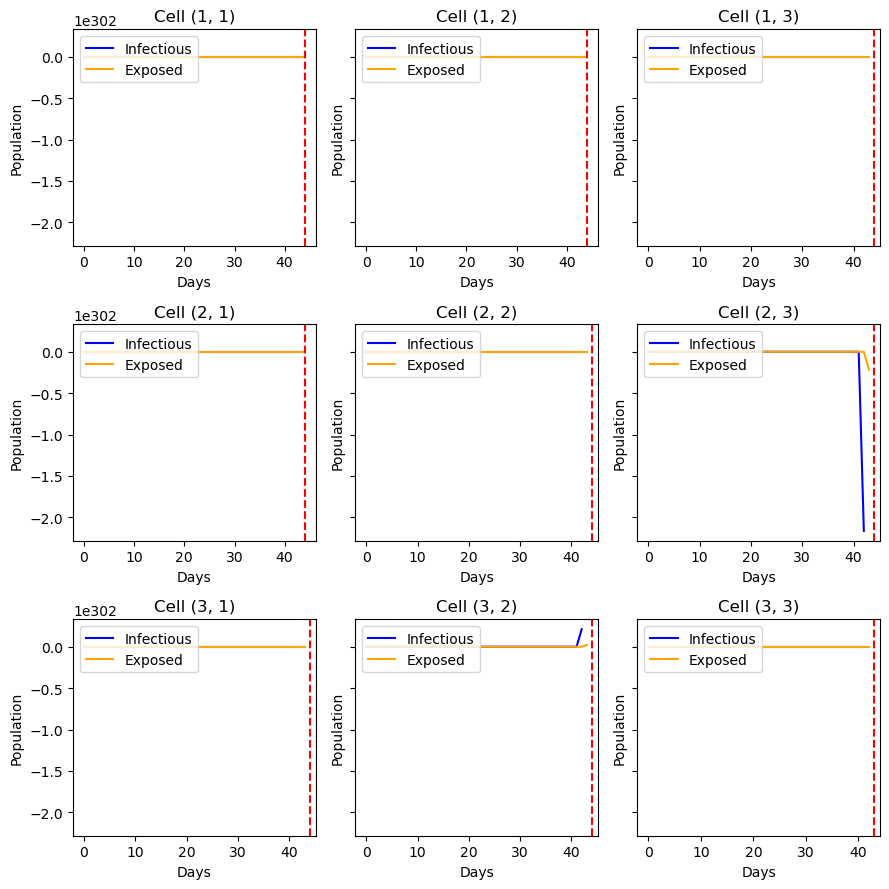

In [42]:
grid_size = 3
pop_grid = np.array([[10000, 10000, 10000],
                     [10000, 50000, 50000],
                     [10000, 50000, 100000]])
initial_infected = (1, 1)
income_values = np.array([0.1, 0.1, 0.1,
                          0.1, 0.2, 0.2,
                          0.1, 0.2, 0.3]) # CONSIDER CHNAGE TO 0.2, 0.1, 0.05

epsilon = 0.9


exposure_rate = 0.3
recovery_rate = 0.1
number_of_days = 100


# Initialize the model
model = initialize_model(grid_size, pop_grid, initial_infected, income_values, epsilon, exposure_rate, recovery_rate)

# Run the simulation
grid_infection, sus_record_case1, exp_record_case1, inf_record_case1, recovery_record_case1 = run_simulation(model, days=number_of_days, dt=1.0)
plot_infectious(inf_record_case1, recovery_record_case1, number_of_days, dt=1.0, plot_recovery=True)

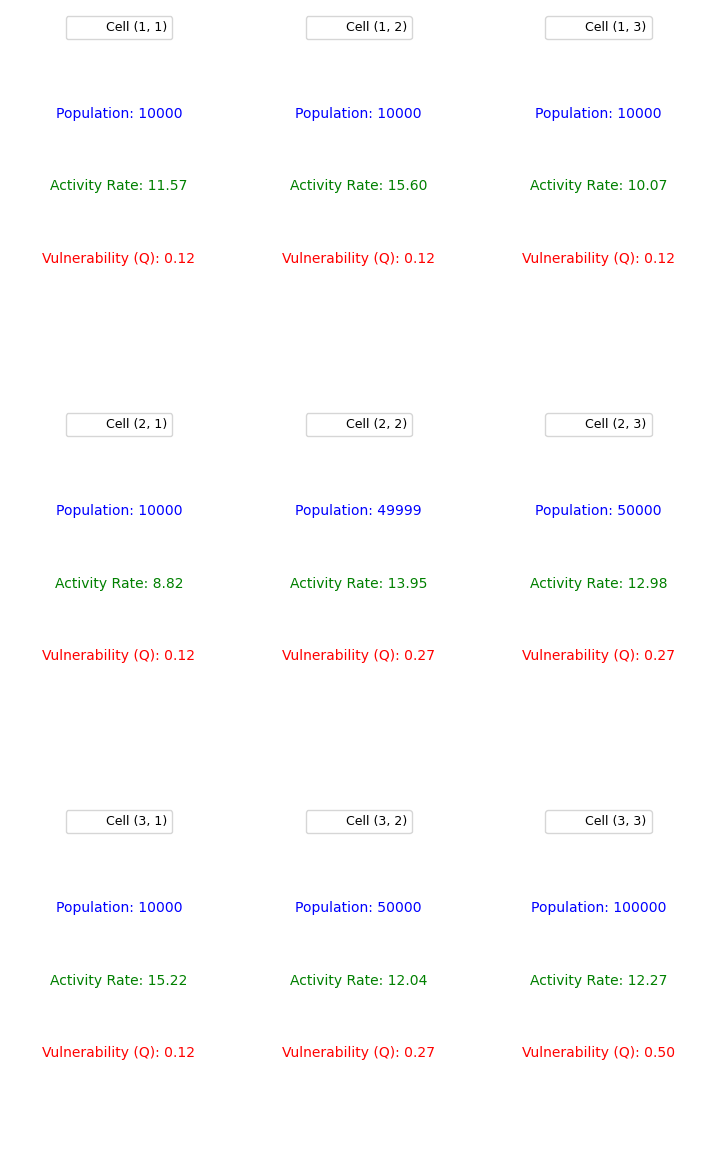

In [43]:
plot_detailed_info(model)

## Experiment 2

set $\epsilon =0.1$, and set $q$ uniformly. How do cell population and activity rate affect the spread over space (start with 1 infected cell).

In [44]:
epsilon_case2 = 0.1

uniform_income_value = 0.1
income_values_case2 = np.full((grid_size**2,), uniform_income_value)


grid_size = 3
pop_grid_case2 = np.array([[10000, 10000, 10000],
                     [10000, 50000, 50000],
                     [10000, 50000, 100000]])
initial_infected = (2, 2)

exposure_rate = 0.3
recovery_rate = 0.1
number_of_days = 100

# initialize the model for CASE 2
model_case2 = initialize_model(grid_size, pop_grid_case2, initial_infected, income_values_case2,
                               epsilon_case2, exposure_rate, recovery_rate)

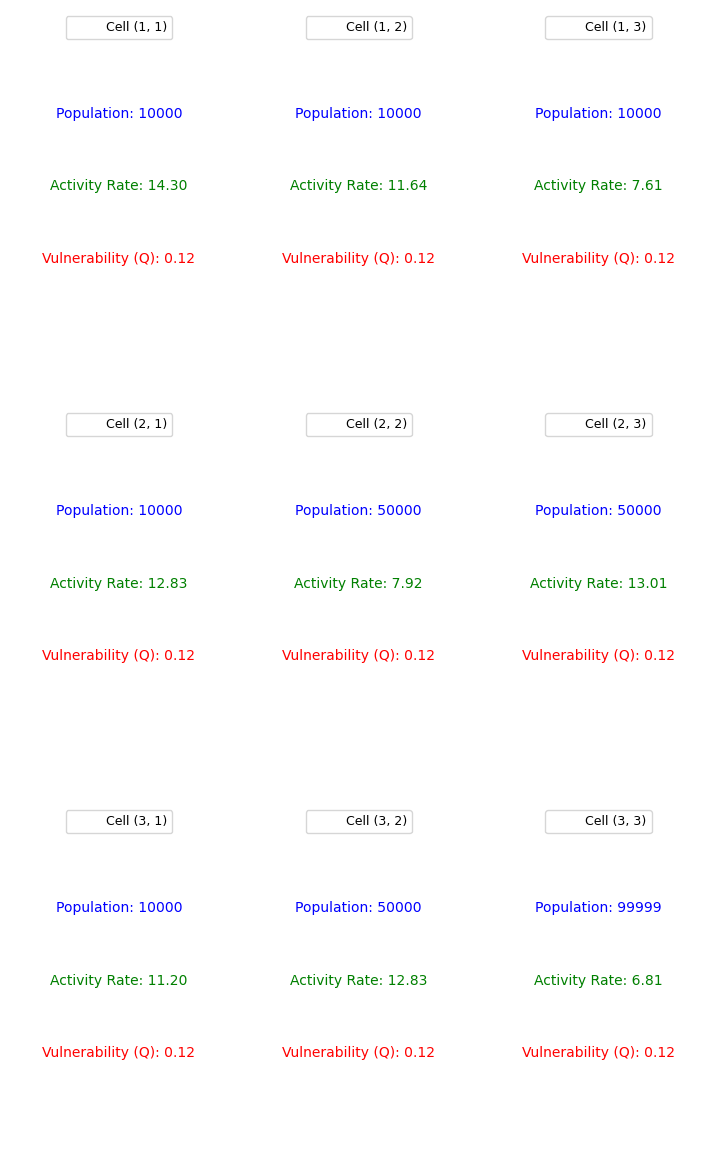

In [45]:
grid_infection_case2, sus_record_case2, exp_record_case2, inf_record_case2, recovery_record_case2 = run_simulation(model_case2, days=number_of_days, dt = 1.0)
plot_detailed_info(model_case2)

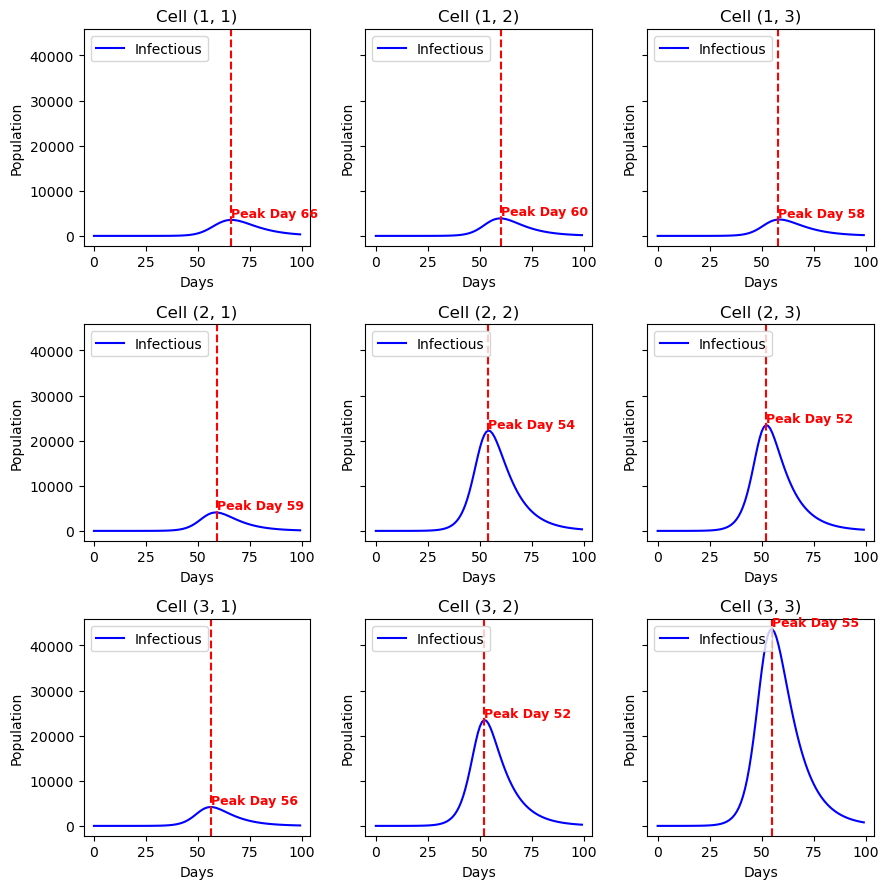

In [46]:
plot_infectious(inf_record_case2, recovery_record_case2, number_of_days, dt=1.0, plot_recovery=False)

## Experiment 3

1. Variability in $q$ (H, M, L)
2. Small $\epsilon$: spatial dependencies.

Does intermobility increase or decrease inequality in outcomes?

Two Sections:
1. array[[H, M, L], [M, L, H], [L, H, M]], this is "inequality at random", no spatial / geographic structure to $q$
2. array[[L, L, L], [L, M, M], [L, M, H]], this is "segregation"

## Experiment 4

1. The first scenario has a homogeneous distribution where every cell has the same $q_i$ equal to the global average (0.1)
2. The second scenario is highly hetergeneous, with some cells having $q_i$ close to zero, and other are higher than global average, while still having the same average $q$ across the grid.

In [47]:
grid_size = 3
pop_grid = np.full((grid_size, grid_size), 10000)

initial_infected = (1, 1)

epsilon = 0.1
exposure_rate = 0.3
recovery_rate = 0.1
number_of_days = 100

In [48]:
average_q = 0.1
homogeneous_q = np.full((grid_size**2,), average_q)

model_homogeneous = initialize_model(grid_size, pop_grid, initial_infected,
                                     homogeneous_q, epsilon,
                                     exposure_rate, recovery_rate)

_, sus_record_homogeneous, exp_record_homogeneous, inf_record_homogeneous, recovery_record_homogeneous = run_simulation(model_homogeneous, days=number_of_days, dt=1.0)

In [49]:
heterogeneous_q = np.array([0.005, 0.005, 0.005, 0.005, 0.25, 0.25, 0.005, 0.25, 0.25])
print(np.mean(heterogeneous_q))

model_heterogeneous = initialize_model(grid_size, pop_grid, initial_infected,
                                       heterogeneous_q, epsilon,
                                       exposure_rate, recovery_rate)

_, sus_record_heterogeneous, exp_record_heterogeneous, inf_record_heterogeneous, recovery_record_heterogeneous = run_simulation(model_heterogeneous, days=number_of_days, dt=1.0)

0.11388888888888887


Homogeneous Case:


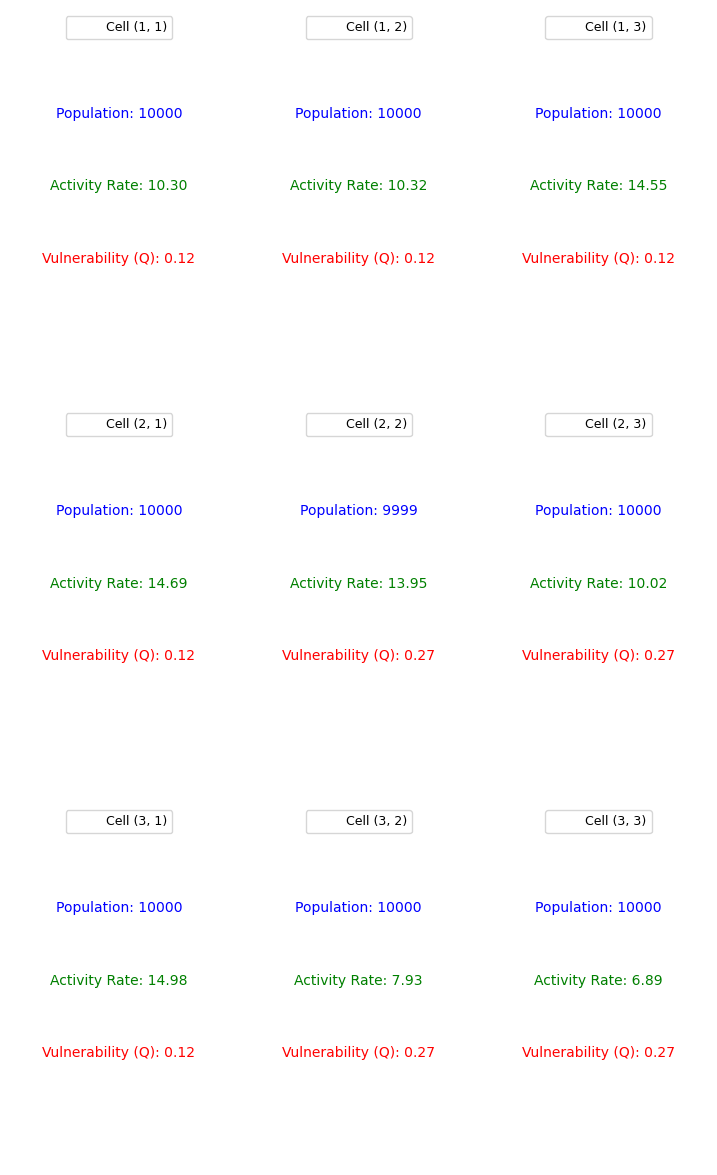

In [50]:
print("Homogeneous Case:")
plot_detailed_info(model_heterogeneous)

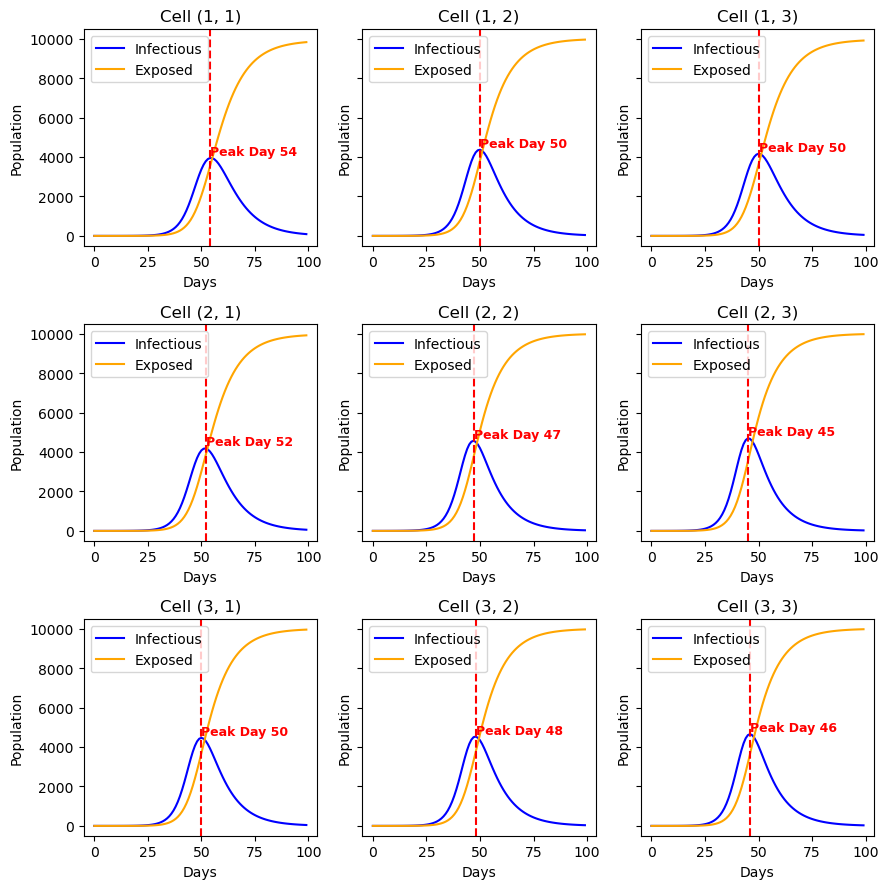

In [51]:
plot_infectious(inf_record_homogeneous, recovery_record_homogeneous, number_of_days, dt=1.0, plot_recovery=True)

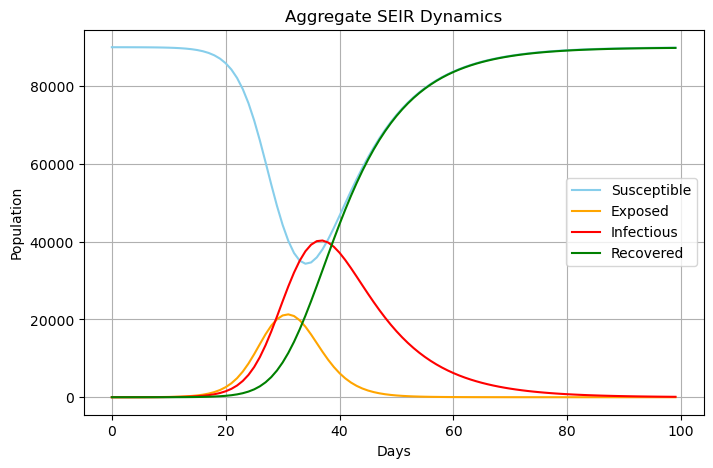

In [52]:
plot_agg_SEIR(sus_record_heterogeneous,
              exp_record_heterogeneous,
              inf_record_heterogeneous,
              recovery_record_heterogeneous,
              pop_grid, number_of_days, dt=1.0)

Heterogeneous Case:


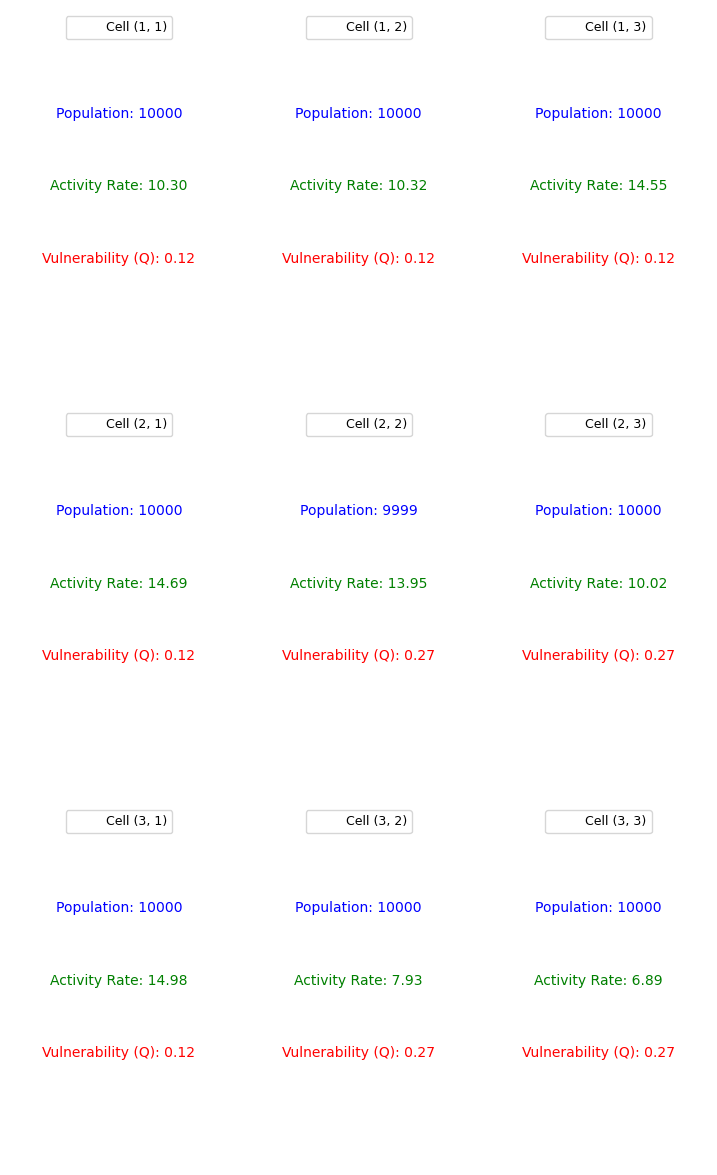

In [53]:
print("Heterogeneous Case:")
plot_detailed_info(model_heterogeneous)

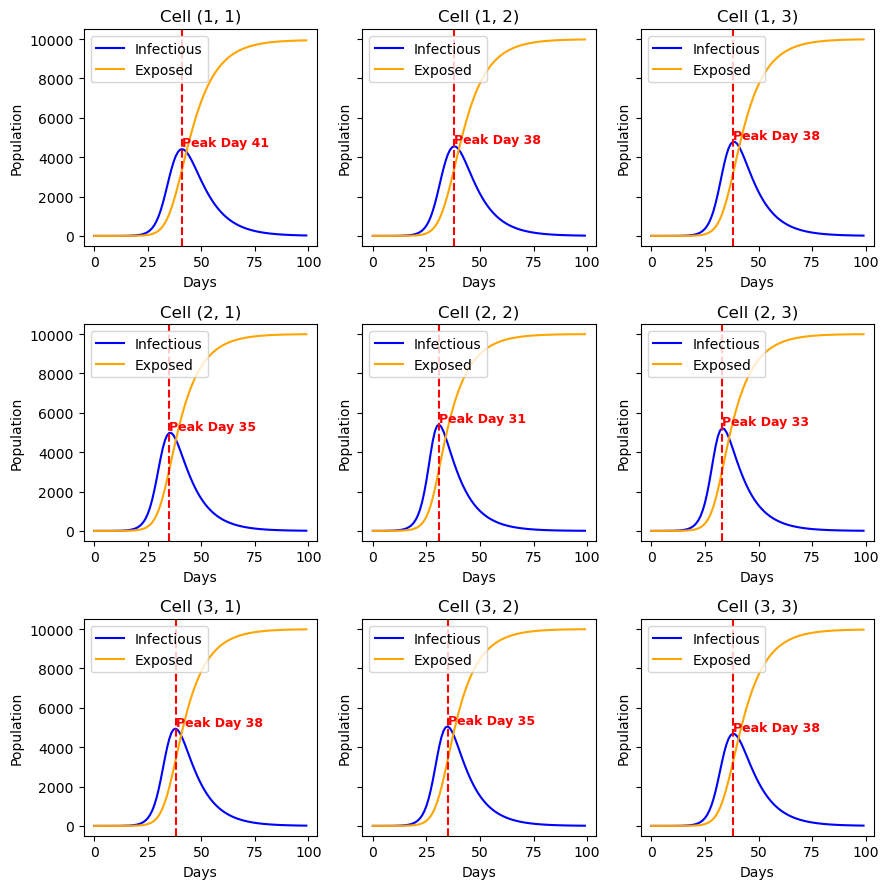

In [54]:
plot_infectious(inf_record_heterogeneous, recovery_record_heterogeneous, number_of_days, dt=1.0, plot_recovery=True)

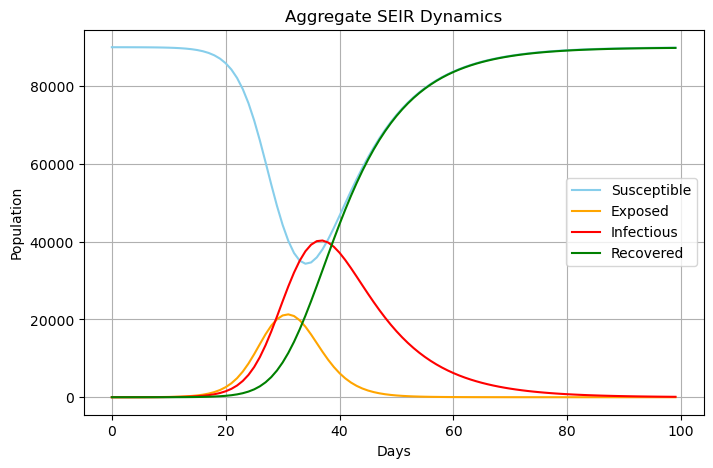

In [55]:
plot_agg_SEIR(sus_record_heterogeneous,
              exp_record_heterogeneous,
              inf_record_heterogeneous,
              recovery_record_heterogeneous,
              pop_grid, number_of_days, dt=1.0)

In [56]:
# def run_simulation_full(model, days=30, dt=1.0):
#     m2 = model.m ** 2
#     X = model.get_initial_state().astype(np.float64)
#     history = np.zeros((m2 * 4, int(days/dt)))  # Storing full history

#     for day in range(int(days/dt)):
#         dXdt = model.derivative(X, day * dt)
#         X += dXdt * dt
#         history[:, day] = X

#     return history

# full_history = run_simulation_full(model_homogeneous, days=number_of_days, dt=1.0)
# plot_SEIR(full_history, number_of_days, grid_size=grid_size)

In [57]:
# full_history = run_simulation_full(model_heterogeneous, days=number_of_days, dt=1.0)
# plot_SEIR(full_history, number_of_days, grid_size=grid_size)